#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [2]:
train = pd.read_csv('dataset/titanic/train.csv')
test = pd.read_csv('dataset/titanic/test.csv')

In [3]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
idtest = test['PassengerId']

#### Pre-processing and Exploratory Data Analysis

##### Outliers - if we are taking random sample, and some observations are at an abnormal distance from the other observations, then we're most probably looking at outliers.

https://www.youtube.com/watch?v=9aDHbRb4Bf8&t=10s

In [6]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterating over dataframe
    for col in features:
        
        # Find 1st quartile
        Q1 = np.percentile(df[col],25)
        
        # Find 3rd quartile
        Q3 = np.percentile(df[col],75)
        
        # Finding Interquartile Range
        IQR = Q3-Q1
        
        # Setting outlier step to 1.5
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3+outlier_step)].index
        
        # appending indices
        outlier_indices.extend(outlier_list_col)
        
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)
    
    return multiple_outliers

In [7]:
c = 'x v v v x v v r r w w w w x x f'.split()
Counter(c)

Counter({'x': 4, 'v': 5, 'r': 2, 'w': 4, 'f': 1})

In [8]:
outliers = detect_outliers(train,2,['Age','SibSp','Fare','Parch'])

outliers

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [9]:
Q1 = np.percentile(train['SibSp'],25)
Q1

0.0

In [10]:
train.shape

(891, 12)

In [11]:
train = train.drop(outliers,axis=0).reset_index(drop=True)
train.shape

(881, 12)

In [12]:
train_len = len(train)

df = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1299 non-null   int64  
 1   Survived     881 non-null    float64
 2   Pclass       1299 non-null   int64  
 3   Name         1299 non-null   object 
 4   Sex          1299 non-null   object 
 5   Age          1043 non-null   float64
 6   SibSp        1299 non-null   int64  
 7   Parch        1299 non-null   int64  
 8   Ticket       1299 non-null   object 
 9   Fare         1298 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1297 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


##### Check for missing values

In [13]:
df.fillna(np.nan,inplace=True)
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

#### Feature Analysis

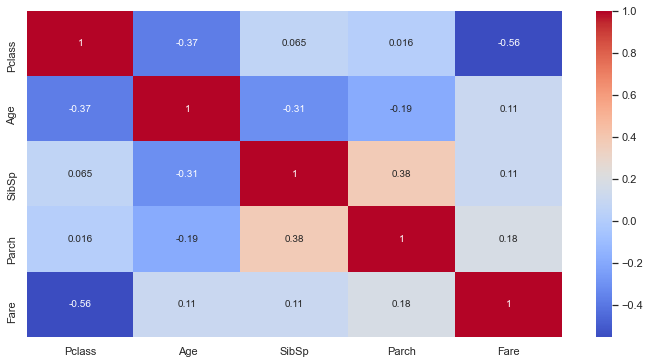

In [14]:
plt.figure(figsize=(12,6))

sns.heatmap(train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(),
            annot=True,
            cmap='coolwarm');

1. Fare is having correlation with pclass and survived.

2. pclass is having correlation with fare and survived and age.

3. sibsp and parch are correlated.

#### Explore sibsp

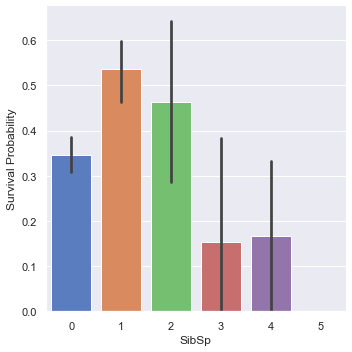

In [15]:
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',palette='muted')

g = g.set_ylabels('Survival Probability')

1. More sibsp less survival esp. >2
2. Single passengers (sibsp=0,1) have higher survival prob. as compared to sibsp >1.

#### Explore Parch

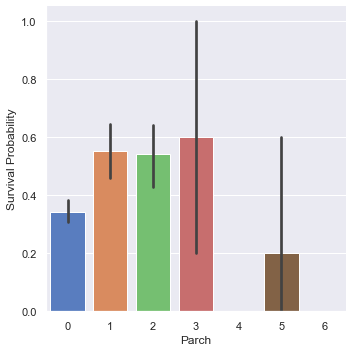

In [16]:
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',palette='muted')

g = g.set_ylabels('Survival Probability')

1. Smaller families have higher chance of survival.

    * Single, when parch = 0
    * small, when parch = 1,2
    * medium, when parch = 3
    * large, when parch > 3

#### Age

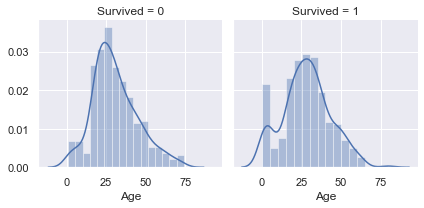

In [17]:
g = sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot,'Age')

1. Age distribution is gaussian in nature.
2. Peaks indicate that younger population survived more.

#### Fare

In [18]:
df['Fare'].isnull().sum()

1

In [19]:
df['Fare'].fillna(df['Fare'].median(),inplace=True)

In [20]:
df['Fare'].isnull().sum()

0

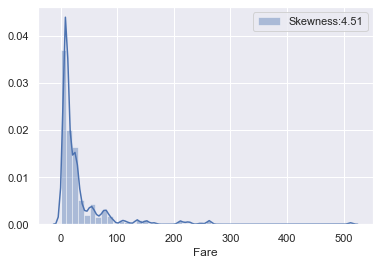

In [21]:
g = sns.distplot(df['Fare'],label='Skewness:%.2f'%df['Fare'].skew())
g = g.legend()

#### We'll use log transformation to remove the skew

In [22]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x>0 else 0)

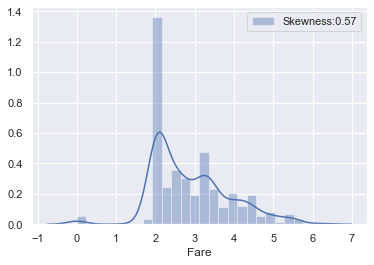

In [23]:
g = sns.distplot(df['Fare'],label='Skewness:%.2f'%df['Fare'].skew())
g = g.legend()

### Categorical Columns

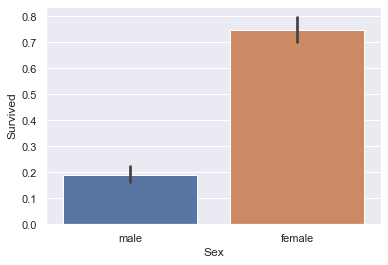

In [24]:
g = sns.barplot(x='Sex',y='Survived',data=train)

#### PClass

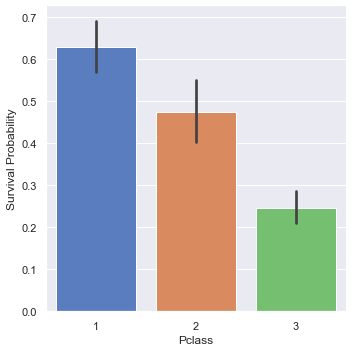

In [25]:
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',palette='muted')

g = g.set_ylabels('Survival Probability')

Pclass = 1 > Pclass = 2 > Pclass = 3

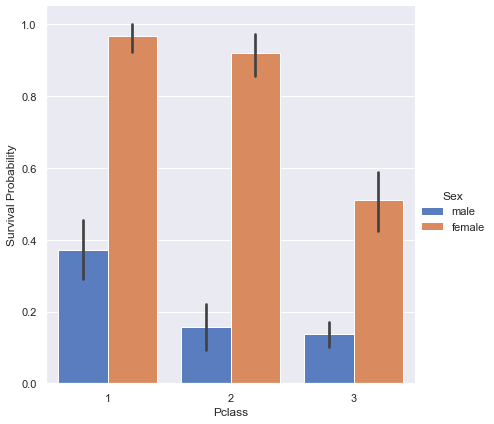

In [26]:
g = sns.factorplot(x='Pclass',
                   y='Survived',
                   data=train,
                   kind='bar',
                   hue='Sex',
                   palette='muted',
                   size=6)
g = g.set_ylabels('Survival Probability')

Trend by gender ratio seems the same

#### Embarked

In [27]:
df['Embarked'].isnull().sum()

2

In [28]:
df['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [29]:
df['Embarked'].fillna('S',inplace=True)

In [30]:
df['Embarked'].isnull().sum()

0

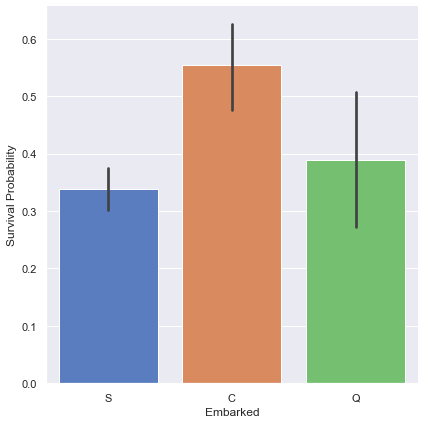

In [31]:
g = sns.factorplot(x='Embarked',
                   y='Survived',
                   data=train,
                   kind='bar',
                   palette='muted',
                   size=6)
g = g.set_ylabels('Survival Probability')

1. Highest prob. of survival is of the people who embarked from cherbourg.

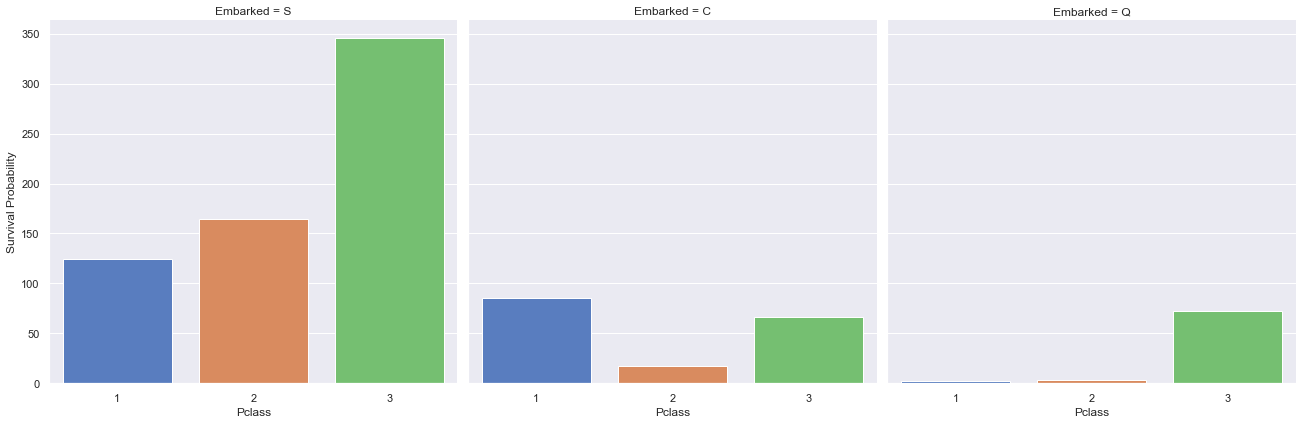

In [32]:
g = sns.factorplot(x='Pclass',
                   col='Embarked',
                   data=train,
                   kind='count',
                   palette='muted',
                   size=6)
g = g.set_ylabels('Survival Probability')

#### Missing value imputations

In [33]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

In [34]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

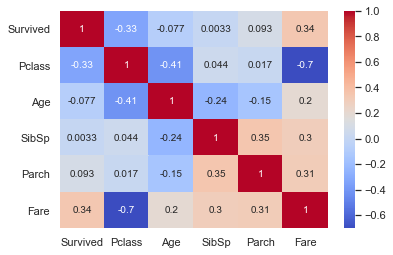

In [35]:
sns.heatmap(df[['Survived', 'Pclass', 'Age', 'SibSp','Parch', 'Fare']].corr(),
            cmap='coolwarm',
            annot=True)

#### Impute Age

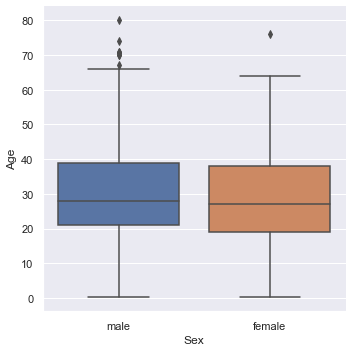

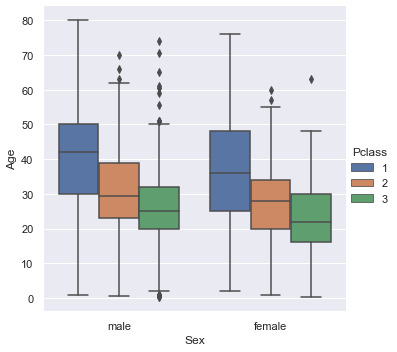

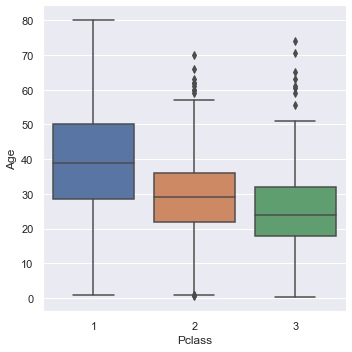

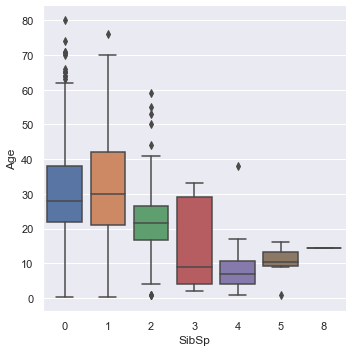

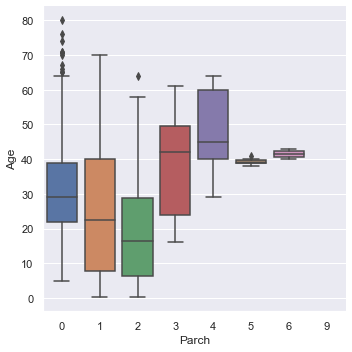

In [36]:
g = sns.factorplot(x='Sex',y='Age',data=df,kind='box')
g = sns.factorplot(x='Sex',y='Age',hue='Pclass',data=df,kind='box')
g = sns.factorplot(x='Pclass',y='Age',data=df,kind='box')
g = sns.factorplot(x='SibSp',y='Age',data=df,kind='box')
g = sns.factorplot(x='Parch',y='Age',data=df,kind='box')

#### We'll use SibSp, Parch, and Pclass for age imputation

In [37]:
index_nan = list(df['Age'][df['Age'].isnull()].index)
age_median = df['Age'].median()

for i in index_nan:
    age_pred = df['Age'][(df['SibSp'] == df.iloc[i]['SibSp'])
                        &(df['Parch'] == df.iloc[i]['Parch'])
                        &(df['Pclass'] == df.iloc[i]['Pclass'])].median()
    
    if not np.isnan(age_pred):
        df['Age'].iloc[i] = age_pred
    else:
        df['Age'].iloc[i] = age_median

In [38]:
# index_nan = 5

# df['Age'].median() = 26

# df['Age'].iloc[5] = 25 so age_pred will be replaced

age_pred = df['Age'][(df['SibSp'] == df.iloc[5]['SibSp'])
                    &(df['Parch'] == df.iloc[5]['Parch'])
                    &(df['Pclass'] == df.iloc[5]['Pclass'])].median()

In [39]:
df['Age'].isnull().sum()

0

#### Name

In [40]:
s = df['Name'][0]
s.split(',')[1].strip().split('.')[0]

'Mr'

In [41]:
df['Title'] = [s.split(',')[1].strip().split('.')[0] for s in df['Name']]

In [42]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,Mr


In [43]:
df['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Capt              1
Jonkheer          1
the Countess      1
Lady              1
Mme               1
Sir               1
Dona              1
Don               1
Name: Title, dtype: int64

In [44]:
df['Title'] = df['Title'].replace(['Don',
                                   'Rev',
                                   'Col',
                                   'Major',
                                   'Capt',
                                   'Jonkheer',
                                   'the Countess',
                                   'Sir',
                                   'Dona',
                                   'Lady',
                                   'Dr',
                                   'Mme',
                                   'Mlle'],'Rare')

In [45]:
df['Title'].value_counts()

Mr        753
Miss      255
Mrs       197
Master     60
Rare       32
Ms          2
Name: Title, dtype: int64

In [46]:
df['Title'] = df['Title'].map({'Mr':0,'Miss':1,'Mrs':1,'Ms':1,'Master':2,'Rare':3})

In [47]:
df['Title'].value_counts()

0    753
1    454
2     60
3     32
Name: Title, dtype: int64

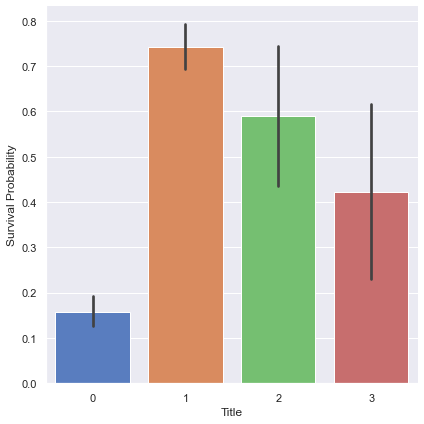

In [48]:
g = sns.factorplot(x='Title',
                   y='Survived',
                   data=df,
                   kind='bar',
                   palette='muted',
                   size=6)
g = g.set_ylabels('Survival Probability')

#### Family Size

Family Size = Parch + SibSp + 1

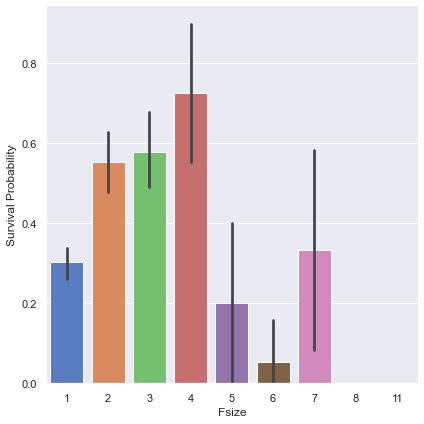

In [49]:
df['Fsize'] = df['Parch']+df['SibSp']+1

g = sns.factorplot(x='Fsize',
                   y='Survived',
                   data=df,
                   kind='bar',
                   palette='muted',
                   size=6)
g = g.set_ylabels('Survival Probability')

In [50]:
df['Single'] = df['Fsize'].map(lambda x: 1 if x==1 else 0)

df['SmallF'] = df['Fsize'].map(lambda x: 1 if x==2 else 0)

df['MediumF'] = df['Fsize'].map(lambda x: 1 if 3 <= x <= 4 else 0)

df['LargeF'] = df['Fsize'].map(lambda x: 1 if x > 4 else 0)

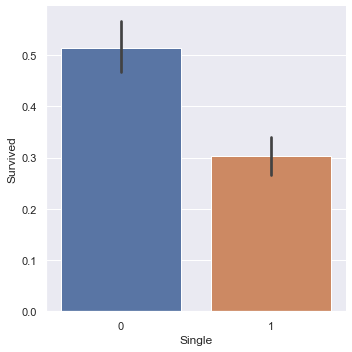

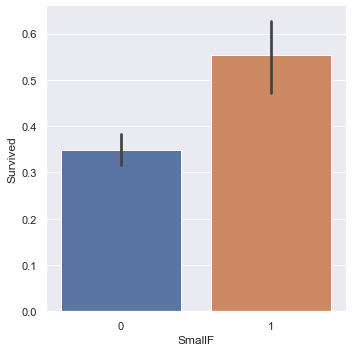

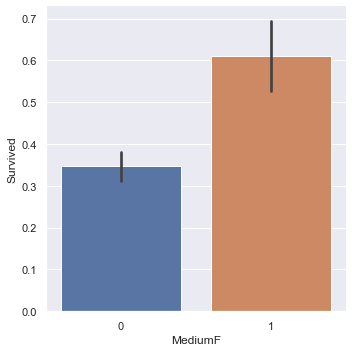

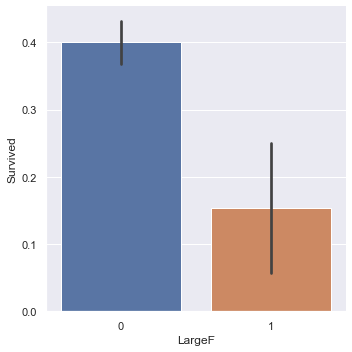

In [51]:
g = sns.factorplot(y='Survived',x='Single',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='SmallF',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='MediumF',data=df,kind='bar')
g = sns.factorplot(y='Survived',x='LargeF',data=df,kind='bar')

In [52]:
df = pd.get_dummies(df,columns=['Title'])

In [53]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Fsize,Single,SmallF,MediumF,LargeF,Title_0,Title_1,Title_2,Title_3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,...,S,2,0,1,0,0,1,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,...,C,2,0,1,0,0,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,...,S,1,1,0,0,0,0,1,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,...,S,2,0,1,0,0,0,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,...,S,1,1,0,0,0,1,0,0,0


##### Encoding

* **Label Encoding**
    * It can turn [Dog,Cat,Dog,Dog,Cat,Dog,Mouse,Mouse] into [1,2,1,1,2,1,3,3]
    * If it would have been ordinal, then average of dog and mouse would've been a cat.
    * **_Advantages_**
        * uses less disk space
    * applied when categorical features are ordinal
    * categorical variables in dataset is huge
    
* **One Hot Encoding**
    * It will turn one categorical feature e.g. Title = Mr Mrs Master Rare into columns Title_Mr, Title_Master, Title_Mrs, Title_Rare.
    * Apply when categorical feature is not ordinal.

#### Cabin

In [54]:
df['Cabin'].head(20)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
Name: Cabin, dtype: object

In [55]:
df['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'])

In [56]:
df['Cabin'].head(20)

0     X
1     C
2     X
3     C
4     X
5     X
6     E
7     X
8     X
9     X
10    G
11    C
12    X
13    X
14    X
15    X
16    X
17    X
18    X
19    X
Name: Cabin, dtype: object

In [57]:
df['Cabin'].value_counts()

X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

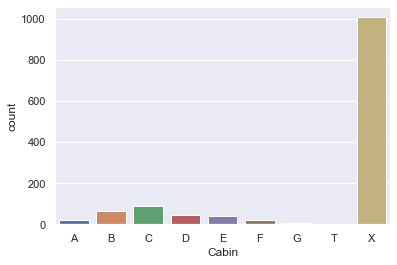

In [58]:
g = sns.countplot(df['Cabin'],order='A B C D E F G T X'.split())

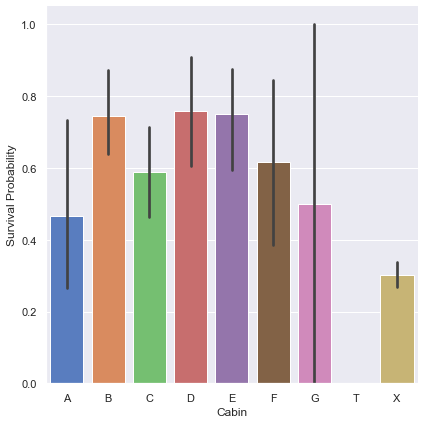

In [59]:
g = sns.factorplot(x='Cabin',
                   y='Survived',
                   data=df,
                   kind='bar',
                   palette='muted',
                   size=6,
                   order='A B C D E F G T X'.split())
g = g.set_ylabels('Survival Probability')

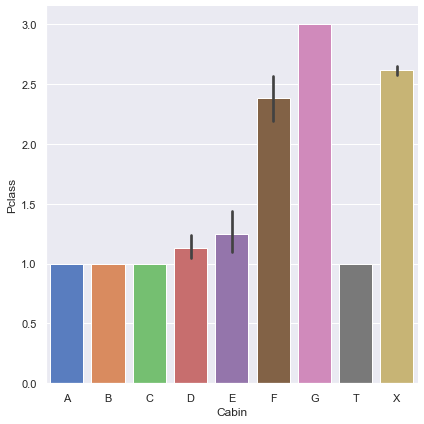

In [60]:
g = sns.factorplot(x='Cabin',
                   y='Pclass',
                   data=df,
                   kind='bar',
                   palette='muted',
                   size=6,
                   order='A B C D E F G T X'.split())
#g = g.set_ylabels('Survival Probability')

In [61]:
df = pd.get_dummies(df,columns=['Cabin'],prefix="Cabin")

In [62]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Fsize', 'Single', 'SmallF',
       'MediumF', 'LargeF', 'Title_0', 'Title_1', 'Title_2', 'Title_3',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

In [63]:
df.drop('Ticket',inplace=True,axis=1)

In [64]:
df['Sex']=df['Sex'].map({'male':0,'female':1})

In [65]:
df.drop('Name',inplace=True,axis=1)

In [66]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Fsize', 'Single', 'SmallF', 'MediumF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_X'],
      dtype='object')

In [67]:
df.drop('Fsize',inplace=True,axis=1)

In [68]:
df = pd.get_dummies(df,columns=['Embarked'],prefix="Embarked")

In [69]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Single', 'SmallF', 'MediumF', 'LargeF', 'Title_0', 'Title_1',
       'Title_2', 'Title_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [70]:
df.drop('SibSp',inplace=True,axis=1)
df.drop('Parch',inplace=True,axis=1)

In [71]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Single',
       'SmallF', 'MediumF', 'LargeF', 'Title_0', 'Title_1', 'Title_2',
       'Title_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1299 non-null   int64  
 1   Survived     881 non-null    float64
 2   Pclass       1299 non-null   int64  
 3   Sex          1299 non-null   int64  
 4   Age          1299 non-null   float64
 5   Fare         1299 non-null   float64
 6   Single       1299 non-null   int64  
 7   SmallF       1299 non-null   int64  
 8   MediumF      1299 non-null   int64  
 9   LargeF       1299 non-null   int64  
 10  Title_0      1299 non-null   uint8  
 11  Title_1      1299 non-null   uint8  
 12  Title_2      1299 non-null   uint8  
 13  Title_3      1299 non-null   uint8  
 14  Cabin_A      1299 non-null   uint8  
 15  Cabin_B      1299 non-null   uint8  
 16  Cabin_C      1299 non-null   uint8  
 17  Cabin_D      1299 non-null   uint8  
 18  Cabin_E      1299 non-null   uint8  
 19  Cabin_

#### Modeling

In [73]:
train = df[:train_len]
test = df[train_len:]

In [74]:
test.drop('Survived',axis=1,inplace=True)

In [75]:
train['Survived'] = train['Survived'].astype(int)

In [76]:
X_train = train.drop('Survived',axis=1)
y_train = train['Survived']

In [77]:
X_train.shape

(881, 25)